# IUM - dokumentacja końcowa
### Autorzy:
- Marcel Kawski 289705
- Konrad Kulesza 300247

## Przygotowanie modeli

### Podusumowanie danych

#### Decyzje/spostrzeżenia odnośnie atrybutów
Większość decyzji podjętych w etapie pierwszym została podtrzymana. Problematyczne okazały się atrybuty dyskretne, które 'one-hot-encodowaliśmy' - rozpatrywane modele mając je dostępne osiągały gorsze wyniki. W dalszej części raportu rozwijamy bardziej tą kwestię
##### Wykorzystywane atrybuty - wejście modelów:
- pleć(z imienia użytkownika)
- cena(średnia, mediana)
- zniżka
- ocena przeglądanych produktów(średnia, minimalna, maksymalna)
- procent wcześniejszych sesji zakończonych sukcesem danego użytkownika
- długość sesji w sekundach
- kategorie produktów
- miasta

##### Wyjście modelu - binarna odpowiedź, czy dana sesja zakończy się sukcesem
Arbitralnie założyliśmy, że sesje uznajemy za zakończoną sukcesem, jeżeli model zwróci prawdopodobieństwo sukcesu większe niż **0.65**

### Modele
- naiwny - zwracający klasę większościową. Do implementacji wykorzystaliśmy bibliotekę `sklearn.dummy`
- właściwy - prosta sieć neuronowa zaimplementowana za pomocą bibliteki `PyTorch`:
    - prosty - gdy nie wykorzystywaliśmy kategorii produktów oraz miast
    - złożony - w p.p.

'Prosty' od 'złożonego' różnią się tylko dodatkową warstwą nauronów oraz liczebnością neuronów w pierwszej warstwie

##### Porównanie modeli - eksperymenty:


`Naiwny/prosty` 
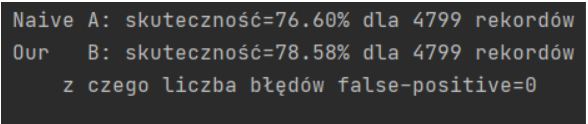
- Pomimo mniej skomplikowanej struktury modelu oraz mniejszej informatywności atrybutów wejściowych jest to najlepszy uzyskany wynik.
- Warto zauważyć, że liczba błędów typu 'false-positive' jest równa zero - bardzo pozytywna cecha, dzięki której możemy przypuszczać, że rzeczywiste wprowazdenie modelu na środowisko produkcyjne przyniesie zauważalny dla przedsiębiorstwa wzrost w przychodach. Wartość ta najprawdopodobniej wynika z faktu ustawienia progu prawdopodobieństa na względnie wysoką wartość.
- Równa liczba rekordów wynika z faktu, że podczas 'karmienia' logów modelu sekwencyjnie zwiększaliśmy ID użytkownika przy każdym zapytaniu zamiast pobierać je z plików. Podejście te nie jest błędne, ponieważ traktujemy rekordy wejściowe jako już ustalone i z tego powodu niezależne od siebie. Jednak, w następnym eksperymencie wykorzystaliśmy `user_id` zapisane w otrzymanych plikach w celu zasymulowania eksperymentu online - zgodnie z wiedzą przekazaną na wykładzie: rekordy tych samych użytkowników *zawsze* trafiały do tego samego modelu.
---

`Naiwny/złożony`
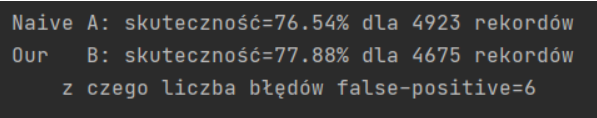
- Model wykorzystujący wszystkie wyselekcjonowane atrybuty
- :iczba błędów 'false-positive' nie jest zerowa, ale dalej mała wzgledem liczby wszystkich zapytń


###### Podsumowanie eksperymentów
- Poza przedstawionymi wyżej eksperymentami, przeprowadziliśmy badania w tych samych warunkach na obu modelach(czyli tak samo dystrybuowane rekordy), ale postanowiliśmy nie umieszczać ich w sprawozdaniu ze względu na ich wtórność, opisalismy tylko te najciekawsze
- Model prostszy okazał się lepszy od zlożonego - przypuszczamy, że wynika to z faktu nieodpowiedniej stuktury modelu 'złożonego' oraz małej informatywności atrybutów `categories` oraz `cities`
- Nie udało nam się spełnić analitycznego kryterium sukcesu podanego w sprawozdaniu wstępnym, jednak przebieg projektu klasyfikujemy pozytywnie

## Aplikacja

##### Opis aplikacji
Prosta aplikacja, umożliwiająca serwowanie predykcji oraz przeprowadzenie powyższych eksperymentów AB. Udostępnia dwa endpointy:
- `GET {url}/predict` - przyjmuje na wejściu wszystkie potrzebne modelom atrybuty, `user_id` w celu przydzielenia zapytania do odpowiedniego modelu oraz `session_id` w celu późniejszego dopasowania. Parzyste do jednego, nieparzyste do drugiego. Zwraca odpowiedź binarną w formie `{"prediction": "False"}`
- `POST {url}/session_result` - przyjmuje na wejściu informacje o sukcesie lub jego braku danej sesji. Nie zwraca żadnej przydatnej informacji. Służy tylko do przyjmowania informacji w celu późniejszej analizy.

Przykład zapytania:
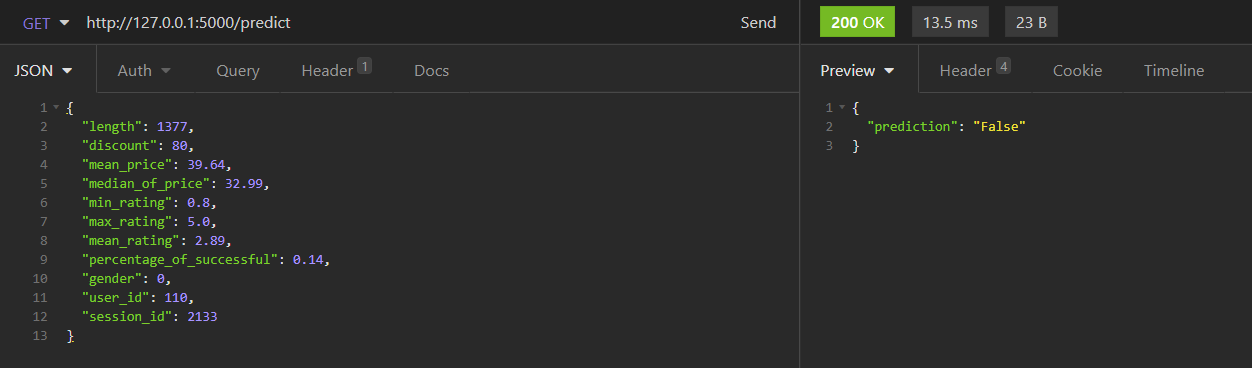

---
Pod spodem aplikacja loguje każde przychodzące zapytanie w formach:
- `Prediction: <model> <session_id> <prediction>`
- `Result: <session_id> <result>`

Kawałem pliku z logami systemu:
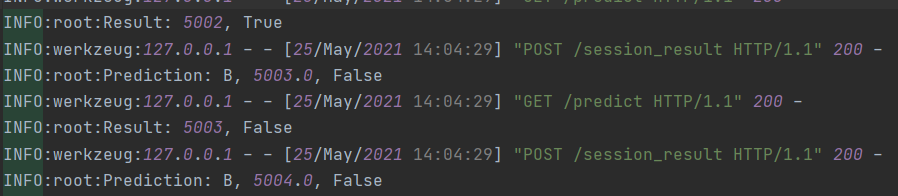

Analiza logów polega na:
1. odczytaniu ich
1. odsianiu logów niezwiązanych z eksperymentem
1. rozdzieleniu predykcji od właściwych rezultatów
1. dopasowaniu wierszy względem `<session_id>`
1. policzeniu poprawnych predykcji dla danych modeli


### 